# GMDL HW2 - PCA and Autoencoders
In this assignment you will implement two dimensionality reduction schemes
we saw in class:
1. Principal Component Analysis (PCA)
2. Autoencoder

You will also implement an image denoising model to enhance the performance of a simple MLP classifier.

The data used in the following exercises is a subset of the MNIST dataset.
Randomly sample 10,000 images from MNIST train set (you may set a random.seed).



In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch import nn, optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from tqdm.auto import tqdm

torch.manual_seed(123)
np.random.seed(123)

# EX1. PCA dimensionality reduction (20pts)

1. Implement the PCA procedure in the function ```perform_PCA()```.

Useful functions:
```
sklearn.preprocessing.StandardScaler
scipy.linalg.eigh
numpy.matmul
```
The input should be in vector form (i.e., flatten the input images beforehand).

2. Project the data to 2D, i.e, $\mathbb{R}^{784}↦ \mathbb{R}^2$.
3. Scatter plot the data using the 2D projection and class labels. You'll need to implement ```plot_projected_data()```


In [ ]:
def pca_svd(X, n_components=2):
    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Perform SVD
    U, S, Vt = np.linalg.svd(X_scaled, full_matrices=False)

    # Select the top n_components
    components = Vt[:n_components].T

    # Project the data
    X_projected = np.dot(X_scaled, components)

    return X_projected, components, scaler

In [ ]:
from sklearn.preprocessing import StandardScaler
from scipy.linalg import eigh
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def perform_PCA(X, n_components):
    # Input: X [numpy array] - shape: (N,784)
    # Output: Projected data using n_components

    # Step 1: Standardize the data
    scaler = StandardScaler()
    X_standardized = scaler.fit_transform(X)

    # Step 2: Compute the covariance matrix
    cov_matrix = np.cov(X_standardized.T)

    # Step 3: Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = eigh(cov_matrix)

    # Step 4: Sort eigenvalues and corresponding eigenvectors in descending order
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    # Step 5: Select the top n_components eigenvectors
    top_eigenvectors = eigenvectors[:, :n_components]

    # Step 6: Project the data onto the new subspace
    projected_data = np.matmul(X_standardized, top_eigenvectors) # matrix multiplication

    return projected_data

    # OR using SVD:
    # Perform SVD
    # U, S, Vt = np.linalg.svd(X_scaled, full_matrices=False)
    # Select the top n_components
    # components = Vt[:n_components].T
    # Project the data
    # X_projected = np.dot(X_scaled, components)
    # return X_projected, components, scaler


def plot_projected_data(X, y, pca=False):
    # Ensure X is 2D
    assert X.shape[1] == 2, "Projected data should be 2D"

    # Create a scatter plot
    plt.figure(figsize=(10, 8))
    colors = plt.cm.viridis(np.linspace(0, 1, 10))
    for digit in range(10):
        mask = y == digit
        plt.scatter(X[mask, 0], X[mask, 1], c=[colors[digit]], label=str(digit), alpha=0.8)


    # Set labels and title
    x_label = 'First Principal Component' if pca else 'Hidden Dimension 1'
    y_label = 'Second Principal Component' if pca else 'Hidden Dimension 2'
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title('2D Projection of Data')

    # Show the plot
    plt.show()

In [ ]:
# Please use the (0.5, 0.5) normalization value,
# as they were used for training the MLP in EX5
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST train and test datasets
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)


# Sample 10K images
train_indices = np.random.choice(len(trainset), 10000, replace=False)
train_subset = Subset(trainset, train_indices)

trainloader = DataLoader(train_subset , batch_size=256, shuffle=True, num_workers=4)
testloader = DataLoader(testset, batch_size=256, shuffle=False, num_workers=4)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 51252172.70it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1545216.39it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4800415.49it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 7113715.00it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw




/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


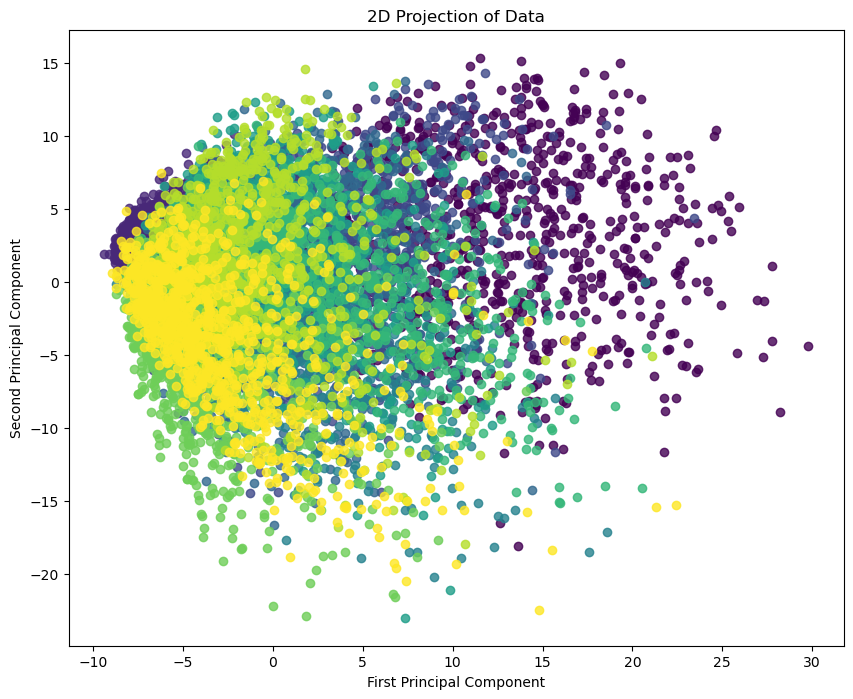

In [ ]:
### Your code goes here ###
# Prepare data for PCA
X = []
y = []

for images, labels in trainloader:
    X.append(images.view(images.size(0), -1).numpy())
    y.extend(labels.numpy())

X = np.concatenate(X, axis=0) # שרשור
y = np.array(y)

# Perform PCA
X_pca_projected = perform_PCA(X, n_components=2)

# Plot projected data
plot_projected_data(X_pca_projected, y, pca=True)

# EX2 Autoencoder (AE)
1. Implement a fully-connected Autoencoder. The encoder and decoder should have 2 layers each. Use ReLU activation function.
2. The so-called 'code' should be two-dimensional. In other words, the output of the encoder should be 2. // 'code' = bottlneck
3. Plot the training loss.

4. Project the data using your AE. Plot the data using ```plot_projected_data()```

In [ ]:
class MLP_AE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=128, code_dim=2):
          super(MLP_AE, self).__init__()

          # Encoder
          self.encoder = nn.Sequential(
              nn.Linear(input_dim, hidden_dim),
              nn.ReLU(),
              nn.Linear(hidden_dim, code_dim)
          )

          # Decoder
          self.decoder = nn.Sequential(
              nn.Linear(code_dim, hidden_dim),
              nn.ReLU(),
              nn.Linear(hidden_dim, input_dim),
              nn.Tanh()  # To match the input range of [-1, 1] due to normalization
          )

    def forward(self,x):
            encoded = self.encoder(x)
            decoded = self.decoder(encoded)
            return decoded


Epoch [10/50], Loss: 0.2067
Epoch [20/50], Loss: 0.1954
Epoch [30/50], Loss: 0.1894
Epoch [40/50], Loss: 0.1844
Epoch [50/50], Loss: 0.1814


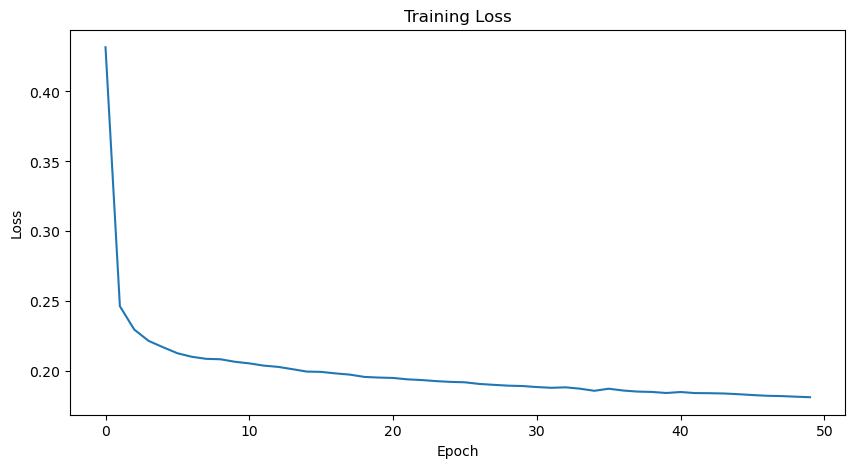

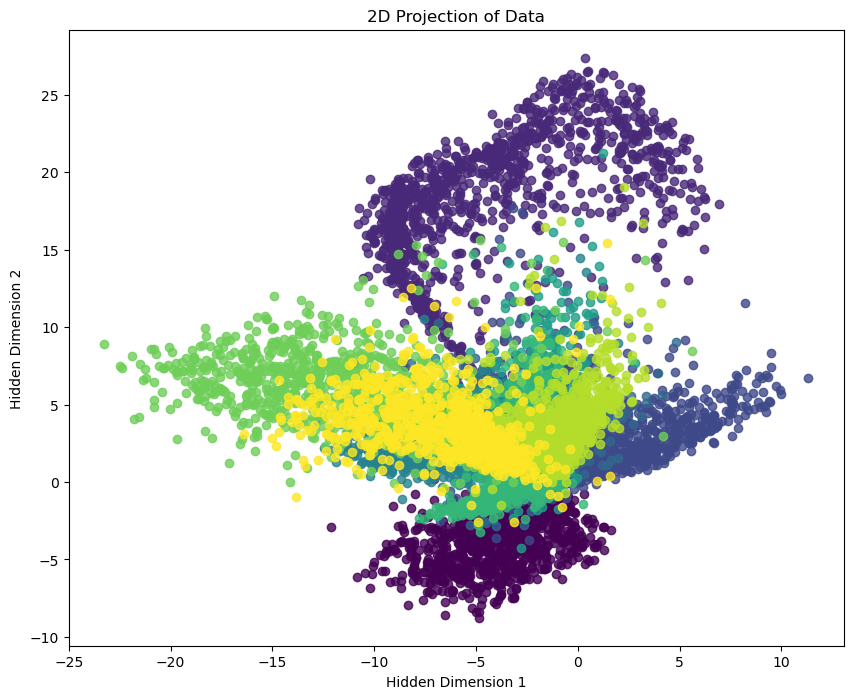

In [ ]:
### Your code goes here ###
# Training function
def train_autoencoder(model, train_loader, num_epochs=50, learning_rate=1e-3):
    criterion = nn.MSELoss() # MESLoss == L2 loss
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    losses = []
    model = model.to(device)
    for epoch in range(num_epochs):
        total_loss = 0
        for batch in train_loader:
            img, _ = batch
            img = img.view(img.size(0), -1)
            img = img.to(device)

            # Forward pass
            reconstruction = model(img)
            loss = criterion(reconstruction, img)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss_epoch = total_loss / len(train_loader)
        losses.append(avg_loss_epoch)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss_epoch:.4f}')

    return losses

# Plot training loss
def plot_loss(losses):
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

# Project data using AE
def project_data_ae(model, data_loader):
    model.eval()
    projected_data = []
    original_imgs = []
    recon_data = []
    labels = []
    model = model.to(device)
    with torch.no_grad():
        for batch in data_loader:
            img, label = batch
            original_imgs.append(img)
            img = img.view(img.size(0), -1).to(device)
            encoded = model.encoder(img)
            reconstructed = model.decoder(encoded).detach().cpu()
            recon_data.append(reconstructed.view(reconstructed.size(0),1,28,28)) # 256 = batch size
            encoded = encoded.detach().cpu() # returning the encoder to the cpu
            projected_data.append(encoded)
            labels.extend(label.numpy())

    projected_data = torch.cat(projected_data, dim=0).numpy() # cat = concate שרשור של טורצ
    recon_data = torch.cat(recon_data, dim=0).numpy()
    original_imgs = torch.cat(original_imgs, dim=0).numpy()
    labels = np.array(labels)

    return projected_data, labels, original_imgs, recon_data

# Initialize and train the autoencoder
model_ae = MLP_AE()
losses_ae = train_autoencoder(model_ae, trainloader)

# Plot the training loss
plot_loss(losses_ae)

# Project the data using the trained autoencoder
projected_data_ae, labels_ae, original_imgs_ae, recon_data_ae = project_data_ae(model_ae, trainloader)

# Plot the projected data
plot_projected_data(projected_data_ae, labels_ae)

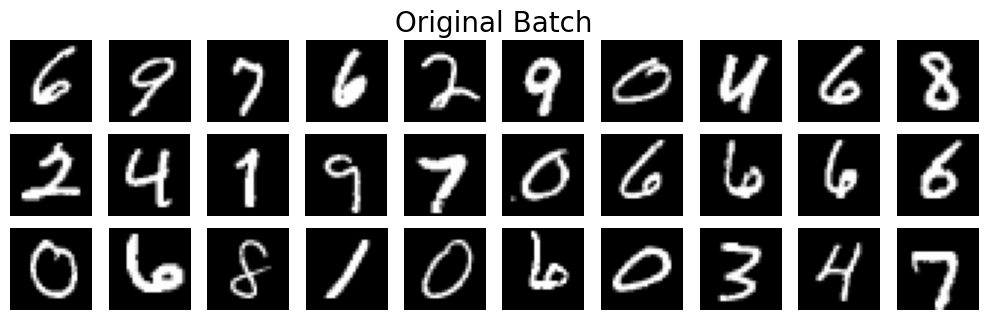

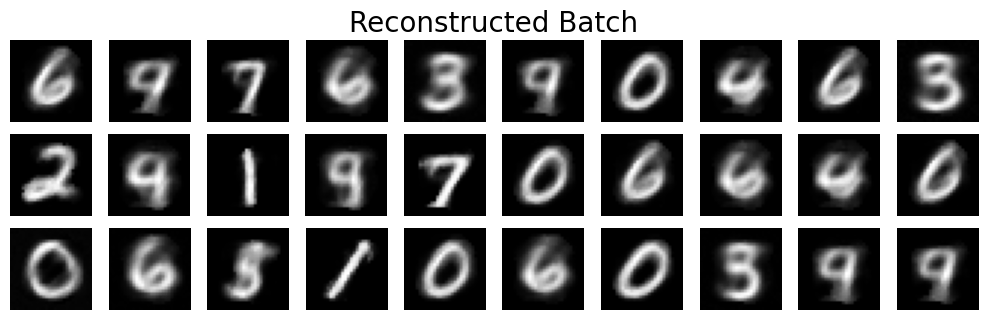

In [ ]:
def plot_images_and_recon(imgs, imgs_recon):
    num_of_images = 30
    total_images = len(imgs)

    # Generate random indices
    random_indices = np.random.choice(total_images, num_of_images, replace=False)

    figure1 = plt.figure(figsize=(10,3))
    for i, index in enumerate(random_indices, 1):
        plt.subplot(3, 10, i) # cause 30 imgs
        plt.axis('off')
        plt.imshow(imgs[index].squeeze(), cmap='gray')
    plt.tight_layout()
    plt.suptitle("Original Batch", y=1.05, fontsize=20)

    figure2 = plt.figure(figsize=(10,3))
    for i, index in enumerate(random_indices, 1):
        plt.subplot(3, 10, i)
        plt.axis('off')
        plt.imshow(imgs_recon[index].squeeze(), cmap='gray')
    plt.suptitle("Reconstructed Batch", y=1.05, fontsize=20)
    plt.tight_layout()
    plt.show()

plot_images_and_recon(original_imgs_ae, recon_data_ae)

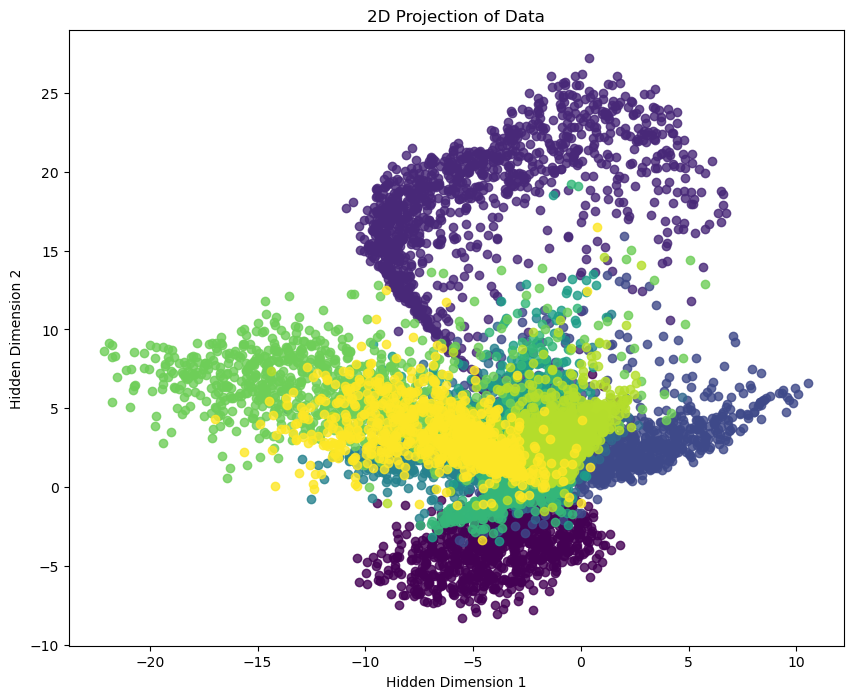

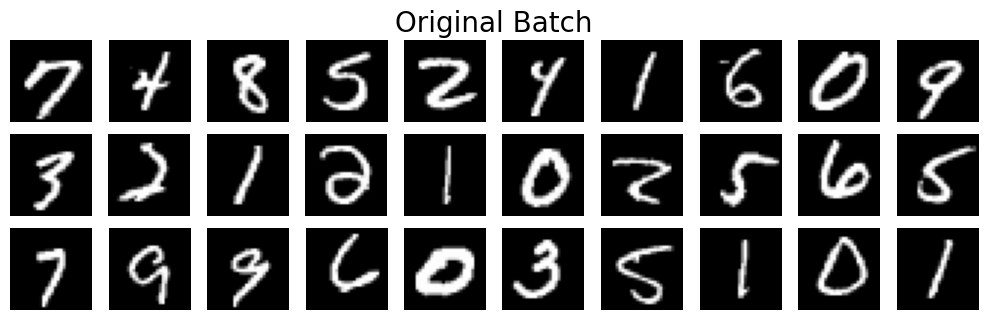

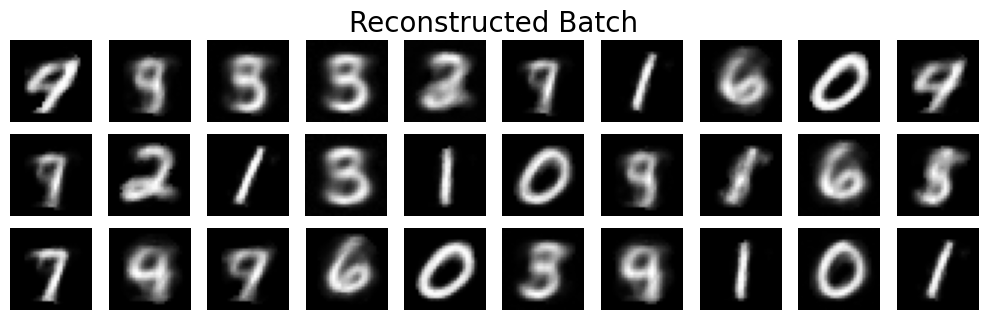

In [ ]:
# plot for the test set:
projected_data_ae_test, labels_test, original_imgs_test, recon_data_ae_test = project_data_ae(model_ae, testloader)
plot_projected_data(projected_data_ae_test, labels_test)
plot_images_and_recon(original_imgs_test, recon_data_ae_test)

# EX3 Linear Autoencoder
1. Follow the steps of EX2, but remove the nonlinear activation functions.

4. Project the data using your AE. Plot the data using ```plot_projected_data()```

In [ ]:
class Linear_AE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=128, code_dim=2):
        super(Linear_AE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
          nn.Linear(input_dim, hidden_dim),
          nn.Linear(hidden_dim, code_dim)
        )

        # Decoder
        self.decoder = nn.Sequential(
          nn.Linear(code_dim, hidden_dim),
          nn.Linear(hidden_dim, input_dim)
        )

    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Epoch [10/50], Loss: 0.2235
Epoch [20/50], Loss: 0.2232
Epoch [30/50], Loss: 0.2230
Epoch [40/50], Loss: 0.2230
Epoch [50/50], Loss: 0.2231


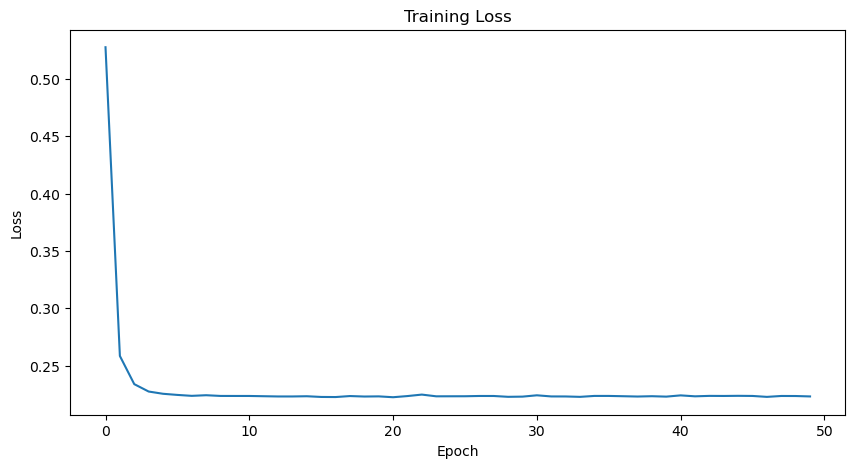

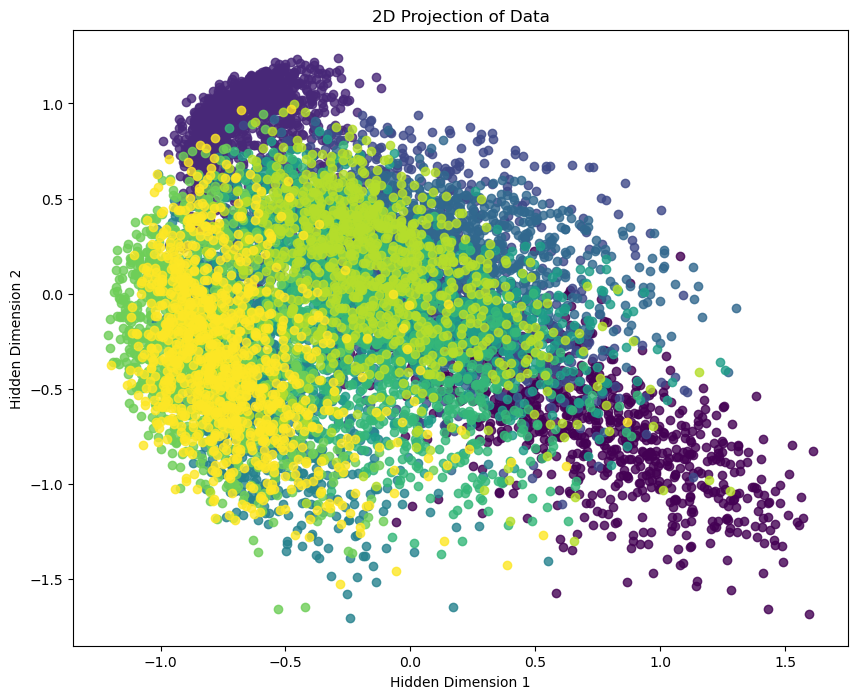

In [ ]:
### Your code goes here ###
# Training function - same from last section
# Plot training loss - same from last section
# Project data using AE - same from last section

# Initialize and train the linear autoencoder
model_lin = Linear_AE()
losses_lin = train_autoencoder(model_lin, trainloader)

# Plot the training loss
plot_loss(losses_lin)

# Project the data using the trained autoencoder
projected_data_lin, labels_lin, original_imgs_lin, recon_data_lin = project_data_ae(model_lin, trainloader)

# Plot the projected data
plot_projected_data(projected_data_lin, labels_lin)

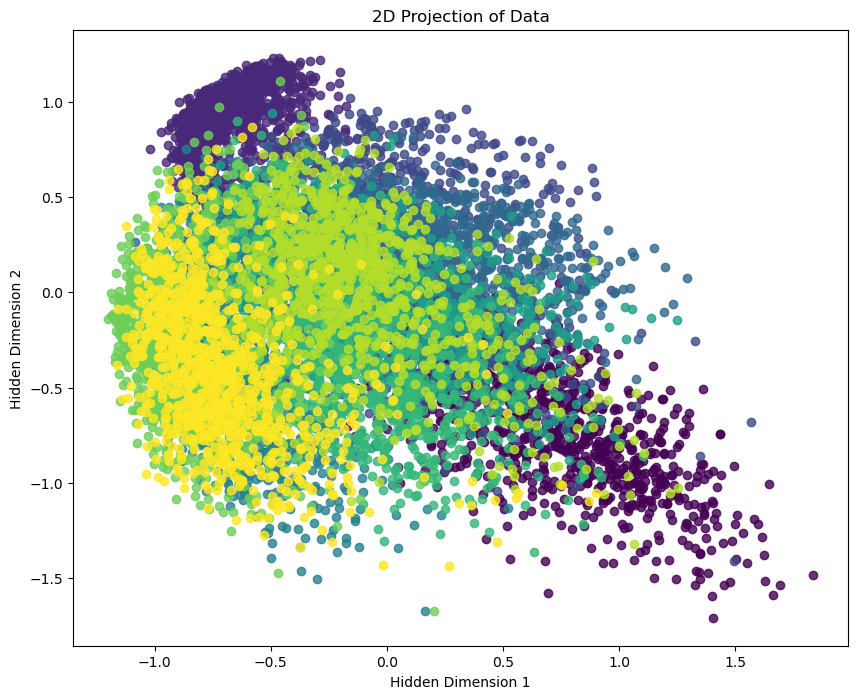

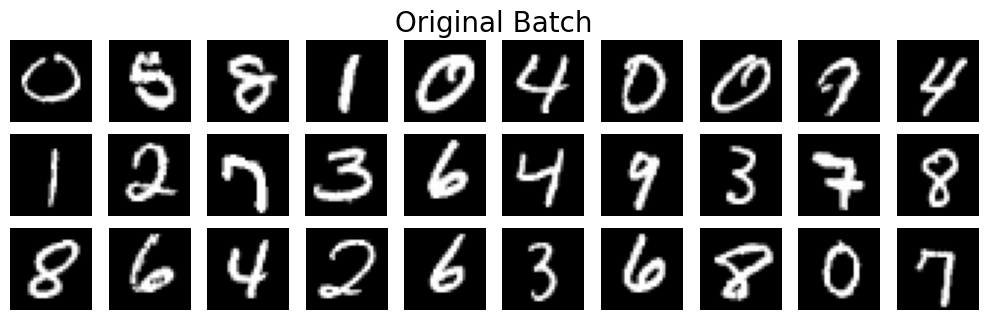

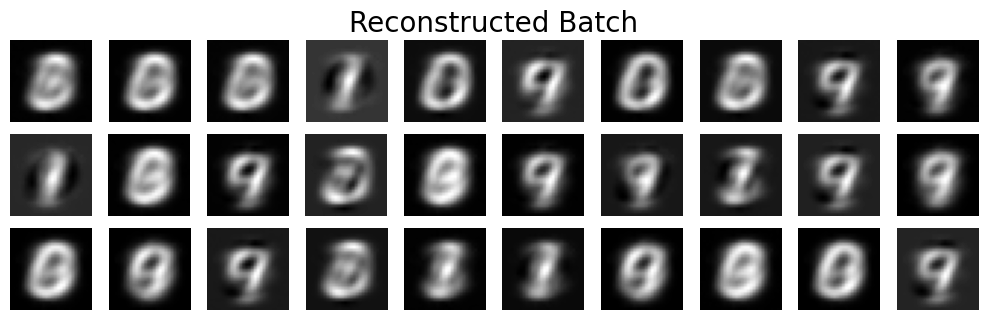

In [ ]:
# plot for the test set:
projected_data_lin_test, labels_test, original_imgs_test, recon_data_lin_test = project_data_ae(model_lin, testloader)
plot_projected_data(projected_data_lin_test, labels_test)
plot_images_and_recon(original_imgs_test, recon_data_lin_test)

# EX 4 - Discussion
1. Write a new plotting function and plot the results side-by-side using subplots.
2. Given the three figures and what we've learned about PCA and AE, answer what are the difference/similarites between the models? How is that indicated in the results?


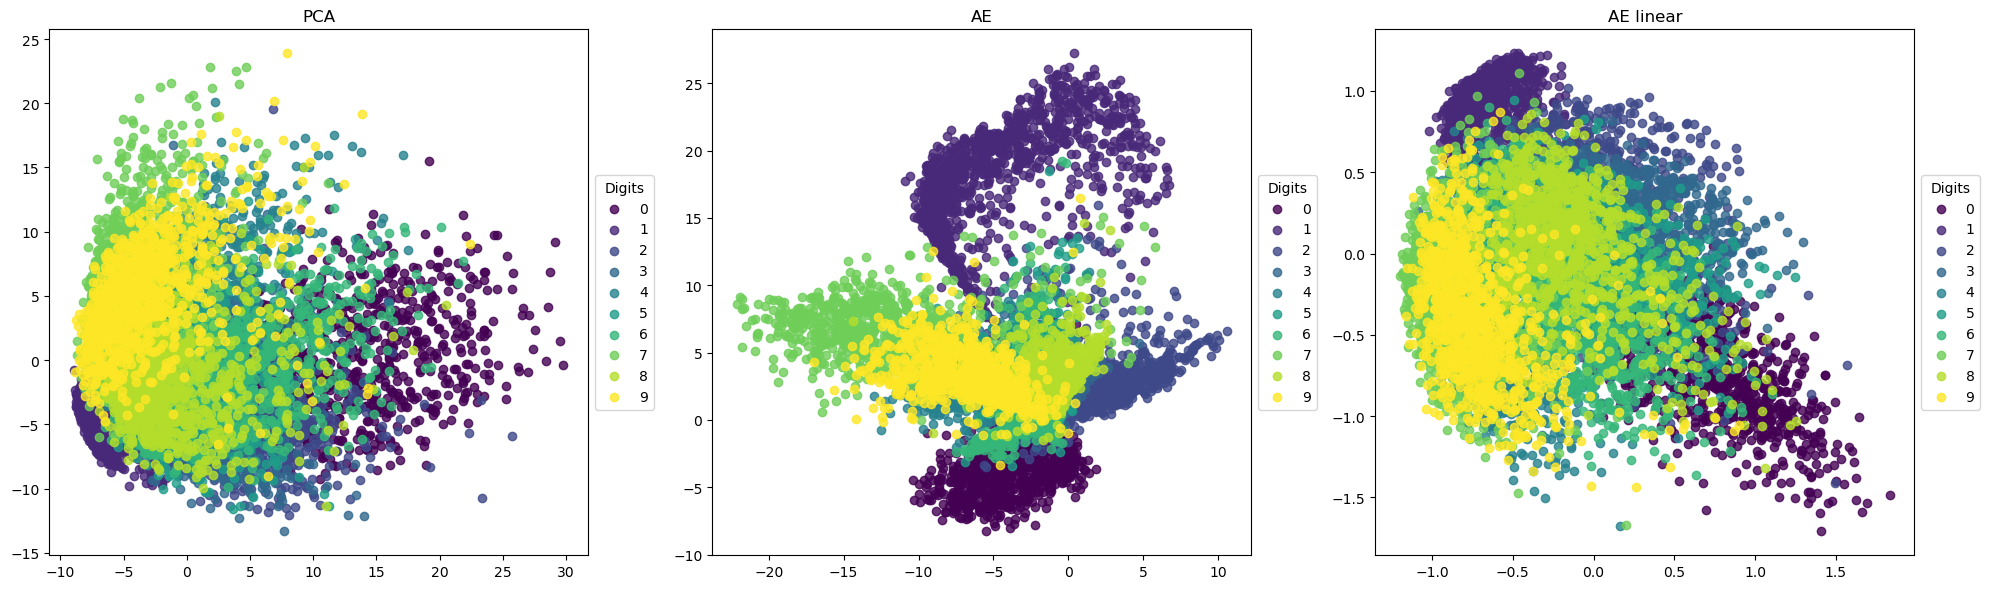

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_projected_data_comparison(X1, X2, X3, y, titles):
    # Ensure all X are 2D
    assert all(X.shape[1] == 2 for X in [X1, X2, X3]), "All projected data should be 2D"

    # Create a figure with 3 subplots side by side
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # Data to plot
    X_list = [X1, X2, X3]

    # Define colors for each digit
    colors = plt.cm.viridis(np.linspace(0, 1, 10))

    # Plot each projection
    for i, (ax, X) in enumerate(zip(axes, X_list)):
        for digit in range(10):
            mask = y == digit
            ax.scatter(X[mask, 0], X[mask, 1], c=[colors[digit]], label=str(digit), alpha=0.8)

        # Set labels and title for each subplot
        ax.set_title(titles[i])

        # Add legend
        ax.legend(title="Digits", loc="center left", bbox_to_anchor=(1, 0.5))

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

# Usage example:
# X1, X2, X3 are your different 2D projections
# y is your target variable
titles = ['PCA', 'AE', 'AE linear']
X_pca_projected_test = perform_PCA(torch.tensor(original_imgs_test).view(original_imgs_test.shape[0],-1).numpy(), n_components=2)
plot_projected_data_comparison(X_pca_projected_test, projected_data_ae_test, projected_data_lin_test, labels_test, titles)

## Theoretical Questions

### The similarities between the models
* All three methods aim to reduce high-dimensional data to a 2D representation.
* They all preserve some structure of the original data, as evident from the distinct clusters and patterns in each plot.


### The differances between the models
*   The PCA shows a more spread-out distribution of points. The scale of the PCA graph is the widest, both in the first and second components, than the non-linear AE and the linear AE.
*  In the PCA and the linear AE subplots, the clusters are less defined and more overlapping than the non-linear AE. Being linear transformations, unable to capture complex nonlinear relationships.
* In the linear AE subplot, the clusters are more defined than PCA but less separated than the other methodes.
* The non-linear AE subplot displays more distinct and separated clusters. Its plot shows a curved, nonlinear structure, especially for the lable '1'. Being non-linear allows it to captures more complex relationships in the data.

### Interpretation
* PCA's result suggests that linear dimensionality reduction may not fully capture the underlying structure of this dataset.
* The nonlinear AE's ability to form more distinct clusters indicates that there are important nonlinear relationships in the data that PCA misses.

### Visualization
We wanted to see a more concrete visualization of how each model reconstruct the digits. The plots below shows that indeed the non-linear AE is better that the linear AE. Although both does't reconstruct the images with the accuracy we would have wanted.

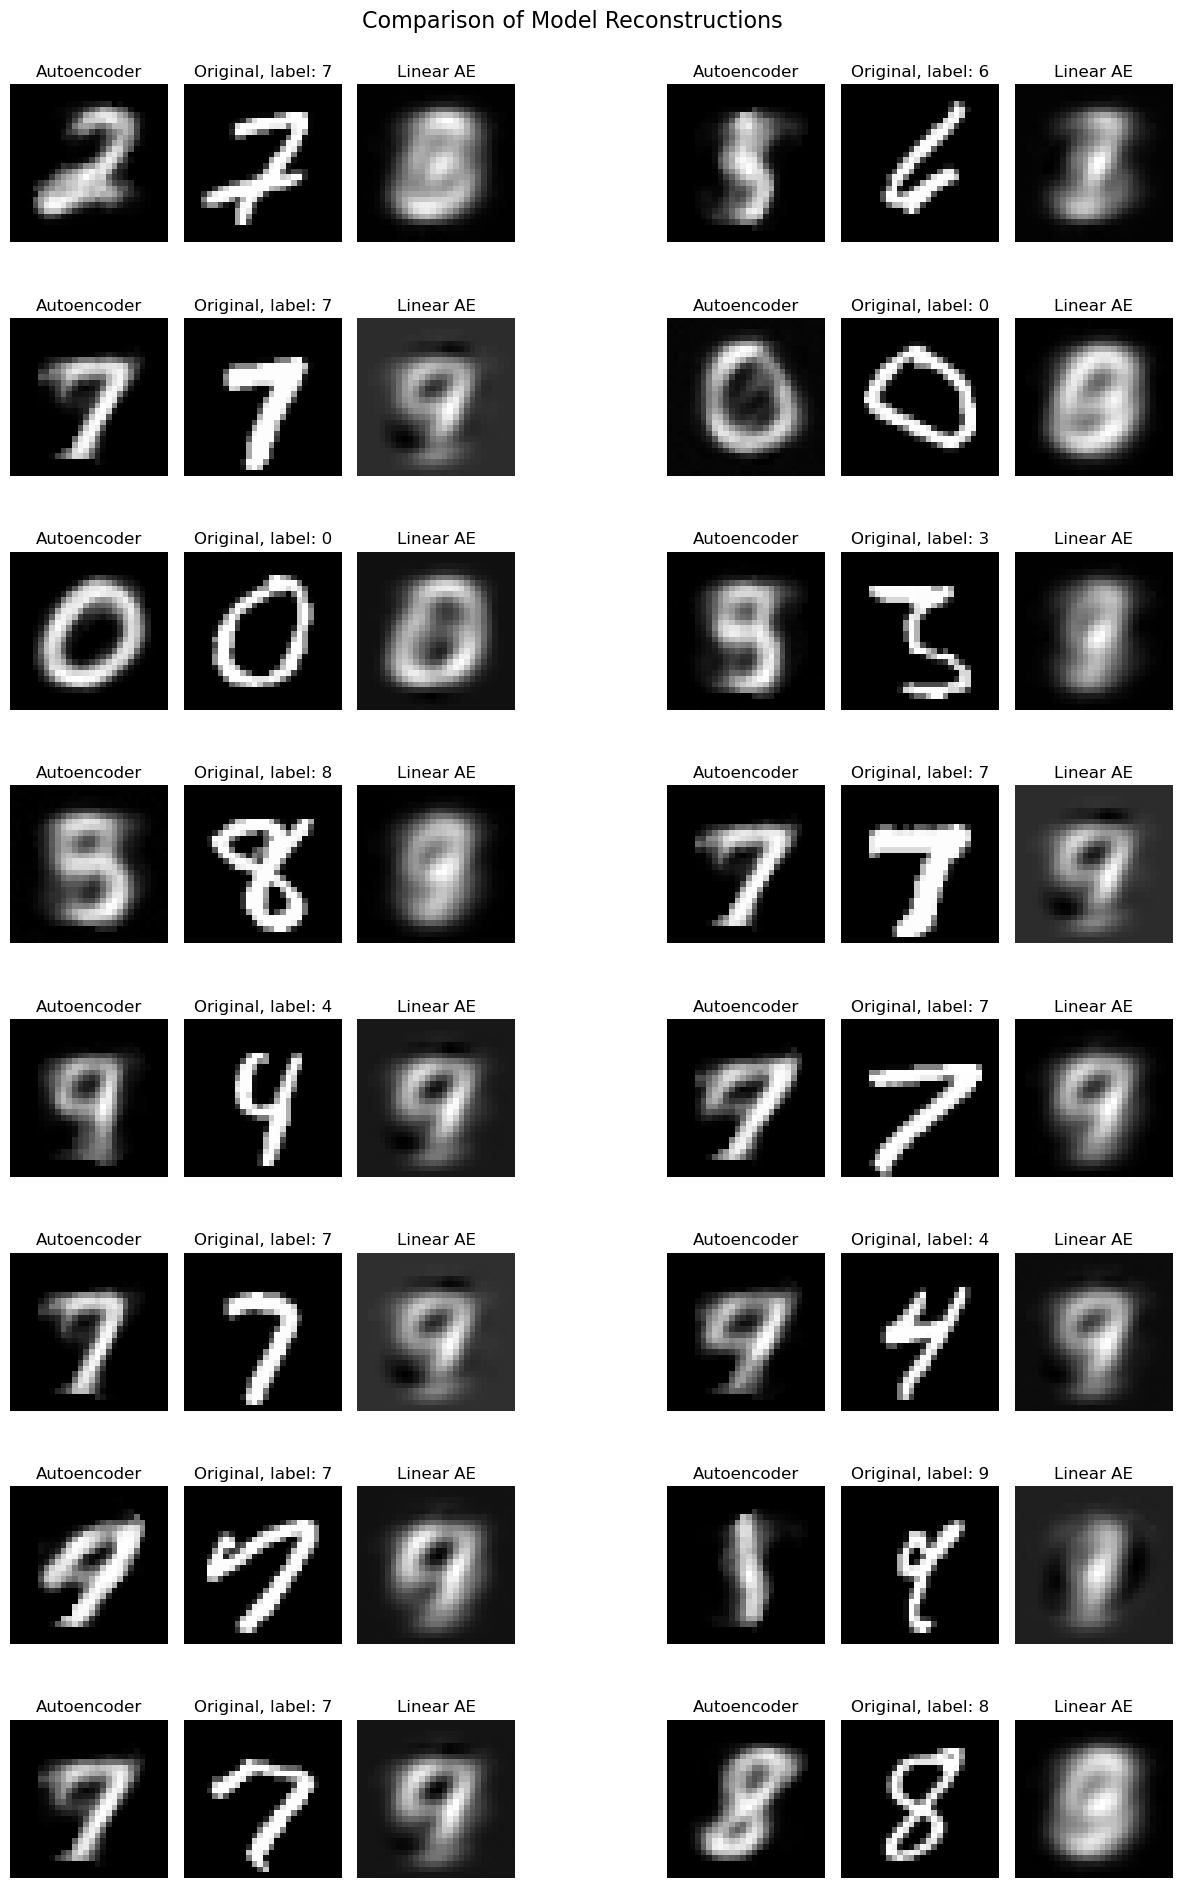

In [ ]:
import random
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def compare_models(model1, model1_name, model2, model2_name, testset, num_samples=10):
    # Randomly select samples
    indices = random.sample(range(len(testset)), num_samples)

    # Calculate the number of rows needed (2 triplets per row)
    num_rows = math.ceil(num_samples / 2)

    # Set up the plot
    fig = plt.figure(figsize=(15, 3 * num_rows))
    gs = gridspec.GridSpec(num_rows, 2, figure=fig, width_ratios=[1, 1], wspace=0.3, hspace=0.1)

    fig.suptitle('Comparison of Model Reconstructions', fontsize=16, y=0.9)

    for i, idx in enumerate(indices):
        # Calculate row and column group indices
        row = i // 2
        col = i % 2

        # Create a sub-gridspec for each triplet
        sub_gs = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[row, col], wspace=0.1)

        # Get the original image
        original_image, label = testset[idx]
        original_image = original_image.squeeze()

        # Run the image through both models
        with torch.no_grad():
            reconstruction1 = model1(original_image.view(1,-1).to(device))
            reconstruction2 = model2(original_image.view(1,-1).to(device))
        reconstruction1 = reconstruction1.view(28, 28).cpu().numpy()
        reconstruction2 = reconstruction2.view(28, 28).cpu().numpy()

        ax1 = fig.add_subplot(sub_gs[0])
        ax1.imshow(reconstruction1, cmap='gray')
        ax1.set_title(model1_name)
        ax1.axis('off')

        ax2 = fig.add_subplot(sub_gs[1])
        ax2.imshow(original_image, cmap='gray')
        ax2.set_title(f'Original, label: {label}')
        ax2.axis('off')

        ax3 = fig.add_subplot(sub_gs[2])
        ax3.imshow(reconstruction2, cmap='gray')
        ax3.set_title(model2_name)
        ax3.axis('off')

    plt.show()

compare_models(model_ae, "Autoencoder", model_lin, "Linear AE", testset, num_samples=16)

# EX 5 - Denoising AE and Classification
In this section you will implement and train a denosing AE to clean corrupted MNIST images.
You are given a trained MLP model (from DL PS1) with ~94% test set accuracy on the cleaned images. Again, work with only 10k images (a subset of the train set).
Your tasks are as follows:
0. Load the mlp.pth file to your project and initiate the MLP model with the trained weights.
1. Compute the test set accuracy for the clean and corrupted datasets.
2. Implemented and train autoencoder to remove the noise.
3. Visualize the results for 10 images, one for each digit (original image, corrupted image, clean image).
4. Compute the test set accuracy on the cleaned/denoised corrupted test set. Due to the randomness of the gaussian noise, run the procedure 5 times and take the average accuracy.

You may not re-train the classification network or train a new model for classification task.

### Grading for this section:
```python
10pts  # code quality and presentation
20pts = max(cleaned image accuracy + 10, 100)*0.2 #(i.e, accuracy >= 90% will give you a full grade).
```



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load trained model

In [ ]:
# MLP classifier from DL PS1 - DO NOT CHANGE
mlp_clf = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mlp_clf.load_state_dict(torch.load('/content/drive/MyDrive/Deep_Learning/HW2/mlp.pth', map_location=torch.device(device)))

<All keys matched successfully>

## Data and functions

In [ ]:
# Noise function - DO NOT CHANGE
def add_gaussian_noise(images, mean=0.0, std=2):
    noise = torch.randn(images.size()) * std + mean
    noisy_images = images + noise
    return noisy_images


# Accuracy - DO NOT CHANGE
def compute_accuracy(model, testloader, denoise_model=None, add_noise=False):
    model.eval()
    model = model.to(device) # ------------> added
    if denoise_model is not None: # ------------> added
        denoise_model.eval()
        denoise_model = denoise_model.to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            # False for clean images, True for corrupted/noisy
            if add_noise:
                  images = add_gaussian_noise(images)
            # Denoise the image before the classifier
            images = images.to(device) # ------------> added
            if denoise_model is not None:  # ------------> added
                  images  = denoise_model(images)
            # reshape to vector form for the MLP
            images = images.view(images.shape[0], -1)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            labels = labels.to(device) # ------------> added
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Different implementation to see different stds:
def compute_accuracy_modified(model, testloader, denoise_model=None, add_noise=False, mean=0.0, std=2):
    model.eval()
    model = model.to(device)
    if denoise_model is not None:
        denoise_model.eval()
        denoise_model = denoise_model.to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            # False for clean images, True for corrupted/noisy
            if add_noise:
                images = add_gaussian_noise(images, mean=mean, std=std)
            # Denoise the image before the classifier
            images = images.to(device)
            if denoise_model is not None:
                images = denoise_model(images)
            # reshape to vector form for the MLP
            images = images.view(images.shape[0], -1)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            labels = labels.to(device)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

In [ ]:
# 1. Compute and print test accuracy for clean and corrupted images
clean_accuracy = compute_accuracy(mlp_clf, testloader)
noisy1_accuracy = compute_accuracy_modified(mlp_clf, testloader, add_noise=True, std=1)
noisy2_accuracy = compute_accuracy(mlp_clf, testloader, add_noise=True)
print(f'''The accuracy for the clean data is {clean_accuracy:.3f},
the accuracy for a noisy data with std 1 is {noisy1_accuracy:.3f},
and the accuracy for a noisy data with std 2 is {noisy2_accuracy:.3f}''')

The accuracy for the clean data is 93.980,
the accuracy for a noisy data with std 1 is 84.410,
and the accuracy for a noisy data with std 2 is 59.160


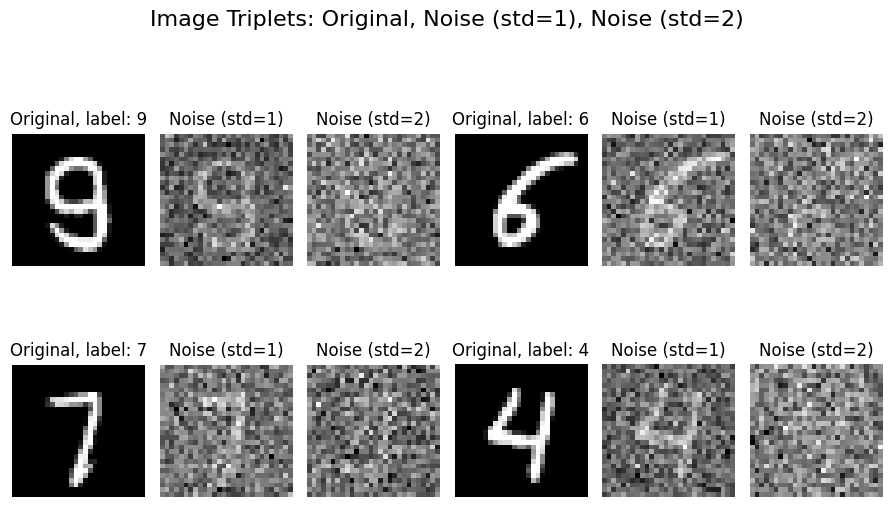

In [ ]:
# Visualization for the noise (on the train and not on the test, so that the test will stay "hidden" from us)
import torch
import matplotlib.pyplot as plt
import random

def compare_gaussian_noise(dataloader, std1, std2, num_images):
    # Get a batch of images
    images, labels = next(iter(dataloader))
    # Select randomly
    indices = random.sample(range(len(images)), num_images)
    # Calc the number of rows needed
    num_rows = (num_images + 1) // 2

    fig, axes = plt.subplots(num_rows, 6, figsize=(9, 3 * num_rows))
    fig.suptitle(f'Image Triplets: Original, Noise (std={std1}), Noise (std={std2})', fontsize=16)

    for i, idx in enumerate(indices):
        row = i // 2
        col = (i % 2) * 3

        image = images[idx].squeeze()
        label = labels[idx].item()

        noisy_image1 = add_gaussian_noise(image.unsqueeze(0), std=std1).squeeze()
        noisy_image2 = add_gaussian_noise(image.unsqueeze(0), std=std2).squeeze()

        # Plot original image
        axes[row, col].imshow(image, cmap='gray')
        axes[row, col].set_title(f'Original, label: {label}')
        axes[row, col].axis('off')

        # Plot noisy image with std1
        axes[row, col + 1].imshow(noisy_image1, cmap='gray')
        axes[row, col + 1].set_title(f'Noise (std={std1})')
        axes[row, col + 1].axis('off')

        # Plot noisy image with std2
        axes[row, col + 2].imshow(noisy_image2, cmap='gray')
        axes[row, col + 2].set_title(f'Noise (std={std2})')
        axes[row, col + 2].axis('off')

    # Remove unused subplots
    for i in range(num_images, num_rows * 2):
        row = i // 2
        col = (i % 2) * 3
        for j in range(3):
            fig.delaxes(axes[row, col + j])

    plt.tight_layout()
    plt.show()

compare_gaussian_noise(testloader, std1=1, std2=2, num_images=4)

In [ ]:
# 2. Implemented and train autoencoder to remove the noise.
class CNNAutoencoder(nn.Module):
    def __init__(self):
        super(CNNAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            self._conv_block(1, 32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            self._conv_block(32, 64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            self._conv_block(64, 128),
            self._conv_block(128, 256),
        )

        # Decoder
        self.decoder = nn.Sequential(
            self._conv_block(256, 128),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            self._conv_block(64, 32),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )


    def _conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels), # normalizing the data withing the process after mapping to another feature space
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels), # normalizing the data withing the process after mapping to another feature space
            nn.ReLU(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 1, 28, 28) # x = [batch_size, 28*28] --> x = [batch_size, channels=1(b&w), height, width]
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = decoded.view(decoded.size(0), -1)# x --> x = [batch_size, 28*28] in order to use the given accuracy function
        return decoded

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch [30/300], Loss: 0.1263
Epoch [60/300], Loss: 0.1019
Epoch [90/300], Loss: 0.0942
Epoch [120/300], Loss: 0.0916
Epoch [150/300], Loss: 0.0877
Epoch [180/300], Loss: 0.0869
Epoch [210/300], Loss: 0.0856
Epoch [240/300], Loss: 0.0850
Epoch [270/300], Loss: 0.0841
Epoch [300/300], Loss: 0.0849


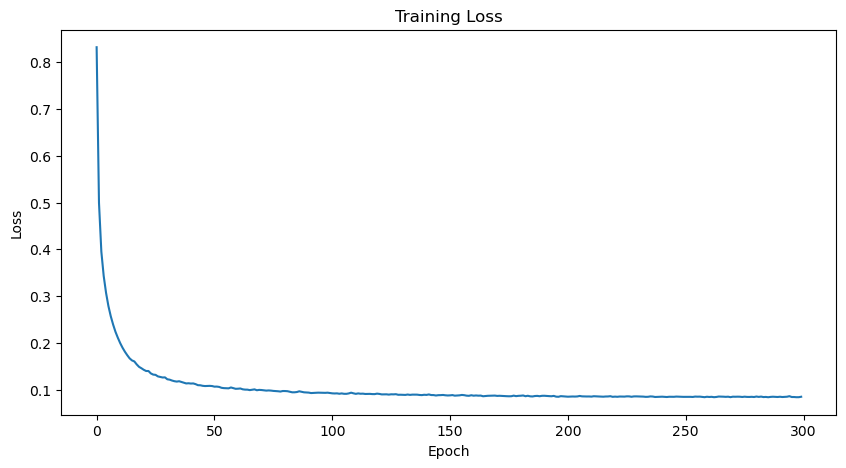

In [ ]:
def train_autoencoder_noisy(model, train_loader, num_epochs=50, learning_rate=1e-3):
    model.train()
    model = model.to(device)
    losses = []
    criterion = nn.MSELoss() # MESLoss == L2 loss
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-2)

    for epoch in tqdm(range(num_epochs)):
        running_loss = 0.0
        for original_images, labels in train_loader:
            noisy_imgs = add_gaussian_noise(original_images)
            original_images = original_images.view(original_images.size(0), -1) # [batch_size, 1, height, width] --> [batch_size, 28*28]
            noisy_imgs = noisy_imgs.view(noisy_imgs.size(0), -1)
            original_images = original_images.to(device)
            noisy_imgs = noisy_imgs.to(device)
            labels = labels.to(device)
            # Forward pass
            reconstruction = model(noisy_imgs)
            loss = criterion(reconstruction, original_images)
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss_epoch = running_loss / len(train_loader)
        losses.append(avg_loss_epoch)
        if (epoch + 1) % 30 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss_epoch:.4f}')

    return losses


# Initialize the model, loss function, and optimizer
denoiser_model = CNNAutoencoder()
losses_ae = train_autoencoder_noisy(denoiser_model, trainloader, num_epochs=300, learning_rate=3e-5)
plot_loss(losses_ae)

In [ ]:
def eval_recon(denoise_model, test_dataloader, std):
    denoise_model.eval()
    denoise_model = denoise_model.to(device)
    mse_loss = 0.0
    with torch.no_grad():
        for original_imgs, labels in test_dataloader:
            noisy_imgs = add_gaussian_noise(original_imgs, std=std)
            original_imgs = original_imgs.view(original_imgs.size(0), -1).to(device)
            noisy_imgs = noisy_imgs.view(noisy_imgs.size(0), -1).to(device)

            denoised_img = denoise_model(noisy_imgs)
            denoised_img = denoised_img.view(noisy_imgs.size(0), -1)
            mse_loss += torch.mean((denoised_img - original_imgs)**2)
        total_mse = (mse_loss / len(test_dataloader)).item()
    return total_mse

noisy2_mse = eval_recon(denoiser_model, testloader, std=2)
noisy1_mse = eval_recon(denoiser_model, testloader, std=1)
print(f'{noisy1_mse=} {noisy2_mse=}')

noisy1_mse=0.05636586621403694 noisy2_mse=0.08664865791797638


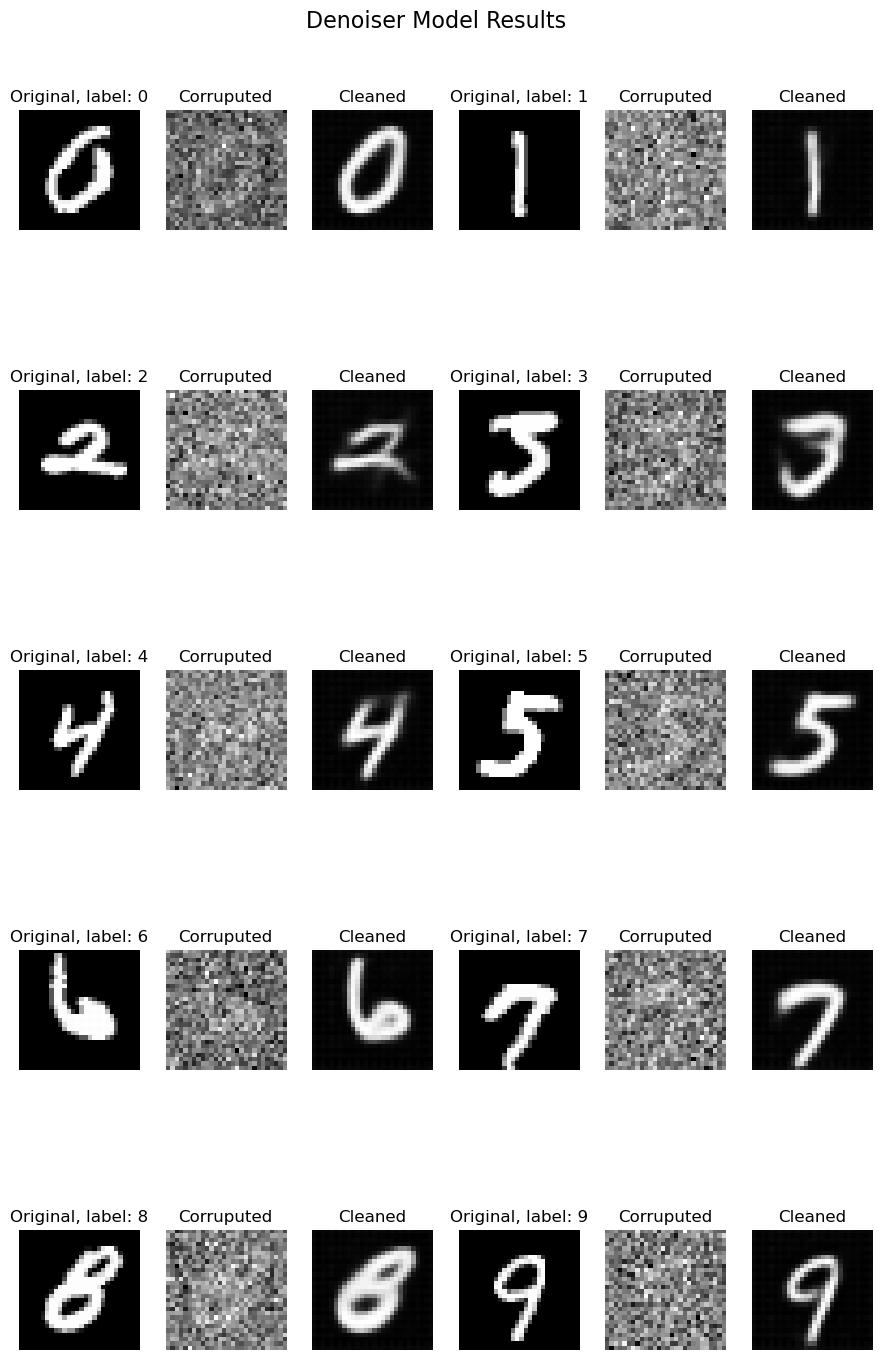

In [ ]:
# 3. Visualize the results for 10 images, one for each digit (original image, corrupted image, clean image).
def compare_gaussian_noise(dataloader, denoiser_model):
    denoiser_model = denoiser_model.to(device)
    denoiser_model.eval()
    dataloader_shuffled = DataLoader(dataloader.dataset, batch_size=1, shuffle=True)

    sampled_images = {}
    for images, labels in dataloader_shuffled:
        img, label = images[0], labels[0].item()
        if label not in sampled_images:
            sampled_images[label] = img.squeeze()
        if len(sampled_images) == 10:
            break

    sampled_images = dict(sorted(sampled_images.items()))

    # Calc the number of rows needed
    num_rows = (10 + 1) // 2

    fig, axes = plt.subplots(num_rows, 6, figsize=(9, 3 * num_rows))
    fig.suptitle(f'Denoiser Model Results', fontsize=16)

    for i, (label, image) in enumerate(sampled_images.items()):
        row = i // 2
        col = (i % 2) * 3

        noised_image = add_gaussian_noise(image)
        noised_image = noised_image.to(device)
        cleaned_image = denoiser_model(noised_image.view(1,-1))
        cleaned_image = cleaned_image.view(28,28).detach().cpu()

        axes[row, col].imshow(image, cmap='gray')
        axes[row, col].set_title(f'Original, label: {label}')
        axes[row, col].axis('off')

        axes[row, col + 1].imshow(noised_image.cpu(), cmap='gray')
        axes[row, col + 1].set_title(f'Corruputed')
        axes[row, col + 1].axis('off')

        axes[row, col + 2].imshow(cleaned_image, cmap='gray')
        axes[row, col + 2].set_title(f'Cleaned')
        axes[row, col + 2].axis('off')

    plt.tight_layout(pad=1.0, h_pad=0.5, w_pad=0.5)
    plt.show()

compare_gaussian_noise(testloader, denoiser_model)

In [ ]:
# 4. Compute the test set accuracy on the cleaned/denoised corrupted test set.
# Due to the randomness of the gaussian noise, run the procedure 5 times and take the average accuracy.

clean_accuracy, noisy1_accuracy, noisy2_accuracy = 0.0, 0.0, 0.0
num_simulations = 5
for i in tqdm(range(num_simulations)):
    clean_accuracy += compute_accuracy(mlp_clf, testloader)
    noisy1_accuracy += compute_accuracy_modified(mlp_clf, testloader, denoise_model=denoiser_model, add_noise=True, std=1)
    noisy2_accuracy += compute_accuracy(mlp_clf, testloader, denoise_model=denoiser_model, add_noise=True)

clean_accuracy, noisy1_accuracy, noisy2_accuracy = clean_accuracy/num_simulations, noisy1_accuracy/num_simulations, noisy2_accuracy/num_simulations
print(f'''The accuracy for the clean data is {clean_accuracy:.3f},
the accuracy for a noisy data with std 1 is {noisy1_accuracy:.3f},
and the accuracy for a noisy data with std 2 is {noisy2_accuracy:.3f}''')


  0%|          | 0/5 [00:00<?, ?it/s]

The accuracy for the clean data is 93.980,
the accuracy for a noisy data with std 1 is 92.792,
and the accuracy for a noisy data with std 2 is 87.160
